In [101]:
import numpy as np
import pandas as pd
import gc
import time
from pickle import dump
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import pickle

In [102]:
df=pd.read_csv('data_useful.csv')

In [103]:
df

,Unnamed: 0,SK_ID_CURR,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AMT_INCOME_TOTAL,DAYS_BIRTH,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,PAYMENT_RATE
0,0,100002,1.0,0.083037,0.262949,0.139376,202500.0,-9461,406597.5,24700.5,-637.0,0.060749
1,1,100003,0.0,0.311267,0.622246,NaN,270000.0,-16765,1293502.5,35698.5,-1188.0,0.027598
2,2,100004,0.0,NaN,0.555912,0.729567,67500.0,-19046,135000.0,6750.0,-225.0,0.050000
3,3,100006,0.0,NaN,0.650442,NaN,135000.0,-19005,312682.5,29686.5,-3039.0,0.094941
4,4,100007,0.0,NaN,0.322738,NaN,121500.0,-19932,513000.0,21865.5,-3038.0,0.042623
...,...,...,...,...,...,...,...,...,...,...,...,...
307502,307502,456251,0.0,0.145570,0.681632,NaN,157500.0,-9327,254700.0,27558.0,-236.0,0.108198
307503,307503,456252,0.0,NaN,0.115992,NaN,72000.0,-20775,269550.0,12001.5,NaN,0.044524
307504,307504,456253,0.0,0.744026,0.535722,0.218859,153000.0,-14966,677664.0,29979.0,-7921.0,0.044239
307505,307505,456254,1.0,NaN,0.514163,0.661024,171000.0,-11961,370107.0,20205.0,-4786.0,0.054592


In [104]:
df=df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)) # c'est pour enlever les caractères spécifiques, est ce bien ça?

In [105]:
df=df.drop('Unnamed0', axis=1)

In [110]:
# Divide in training/validation and test data
train_df = df[:100000]
test_df = df[100000:160000]
print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

Starting LightGBM. Train shape: (100000, 11), test shape: (60000, 11)


In [113]:
num_folds=2
# Cross validation model
folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
# Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
feats = [f for f in train_df.columns if f not in ['TARGET']]

In [114]:
oof_preds = np.zeros(train_df.shape[0])

In [115]:
oof_preds.shape

(100000,)

In [116]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

In [117]:
visu=feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index

NameError: name 'feature_importance_df_' is not defined

/home/justin/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/justin/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/justin/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.790503	training's binary_logloss: 0.238051	valid_1's auc: 0.745076	valid_1's binary_logloss: 0.250066
[400]	training's auc: 0.809563	training's binary_logloss: 0.231161	valid_1's auc: 0.745848	valid_1's binary_logloss: 0.24972
Fold  1 AUC : 0.746008


/home/justin/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/justin/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/justin/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.789344	training's binary_logloss: 0.237944	valid_1's auc: 0.741363	valid_1's binary_logloss: 0.250875
[400]	training's auc: 0.807669	training's binary_logloss: 0.231365	valid_1's auc: 0.744298	valid_1's binary_logloss: 0.250235
[600]	training's auc: 0.821997	training's binary_logloss: 0.226308	valid_1's auc: 0.743683	valid_1's binary_logloss: 0.250488
Fold  2 AUC : 0.744445
Full AUC score 0.745207


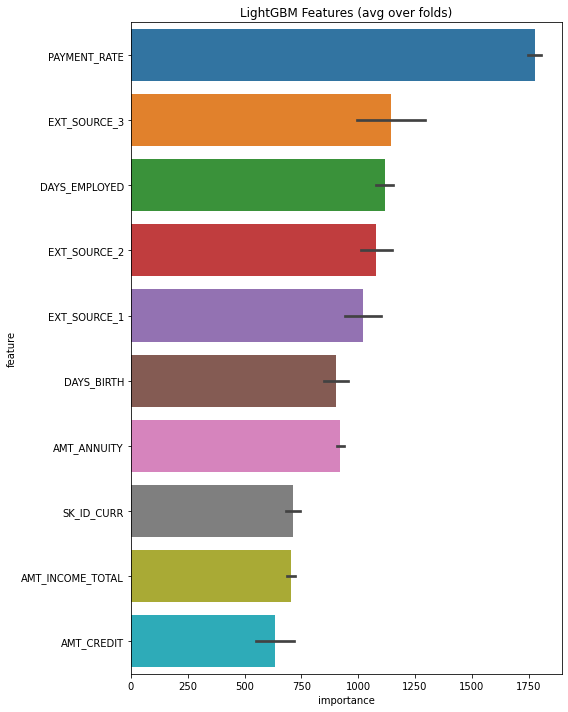

In [118]:
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
    train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
    valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

    # LightGBM parameters found by Bayesian optimization
    clf = LGBMClassifier(
        nthread=4,
        n_estimators=10000,
        learning_rate=0.02,
        num_leaves=34,
        colsample_bytree=0.9497036,
        subsample=0.8715623,
        max_depth=8,
        reg_alpha=0.041545473,
        reg_lambda=0.0735294,
        min_split_gain=0.0222415,
        min_child_weight=39.3259775,
        silent=-1,
        verbose=-1, )

    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
        eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

    filename = 'finalized_model.pickle'
    pickle.dump(clf, open(filename, 'wb'))

    oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()

print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
# Write submission file and plot feature importance
display_importances(feature_importance_df)

In [119]:
clf

NameError: name 'clf' is not defined

In [122]:
test_df[feats]

,SK_ID_CURR,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AMT_INCOME_TOTAL,DAYS_BIRTH,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,PAYMENT_RATE
100000,216094,NaN,0.519509,0.739412,112500.0,-17547,835380.0,40189.5,-9756.0,0.048109
100001,216095,NaN,0.334237,NaN,112500.0,-20790,765261.0,32422.5,NaN,0.042368
100002,216097,NaN,0.522587,0.443615,202500.0,-12807,675000.0,43267.5,-1230.0,0.064100
100003,216098,0.399226,0.515244,0.502878,166500.0,-13214,900000.0,26446.5,-6104.0,0.029385
100004,216099,NaN,0.688380,0.572683,107500.5,-21886,299250.0,8226.0,-4687.0,0.027489
...,...,...,...,...,...,...,...,...,...,...
159995,285474,NaN,0.739543,0.135951,126000.0,-20288,900000.0,26316.0,NaN,0.029240
159996,285475,NaN,0.340646,0.463275,90000.0,-17642,640080.0,31261.5,-3628.0,0.048840
159997,285477,NaN,0.699028,0.621226,270000.0,-15102,1006920.0,70078.5,-3229.0,0.069597
159998,285478,0.821623,0.469415,0.600658,103500.0,-22510,536917.5,27544.5,NaN,0.051301


In [123]:
with open('finalized_model.pickle', 'rb') as handle:
    model= pickle.load(handle)

In [124]:
model

LGBMClassifier(colsample_bytree=0.9497036, learning_rate=0.02, max_depth=8,
               min_child_weight=39.3259775, min_split_gain=0.0222415,
               n_estimators=10000, nthread=4, num_leaves=34,
               reg_alpha=0.041545473, reg_lambda=0.0735294, silent=-1,
               subsample=0.8715623, verbose=-1)

In [125]:
model.predict_proba(test_df[feats][10:50]) # echantillon de 10 et 50

array([[0.89734399, 0.10265601],
       [0.91684278, 0.08315722],
       [0.78268176, 0.21731824],
       [0.79469087, 0.20530913],
       [0.9545107 , 0.0454893 ],
       [0.9451257 , 0.0548743 ],
       [0.97218907, 0.02781093],
       [0.87030655, 0.12969345],
       [0.94052965, 0.05947035],
       [0.88381855, 0.11618145],
       [0.92821887, 0.07178113],
       [0.94240617, 0.05759383],
       [0.89153283, 0.10846717],
       [0.96445731, 0.03554269],
       [0.89419337, 0.10580663],
       [0.95582281, 0.04417719],
       [0.92501135, 0.07498865],
       [0.93939065, 0.06060935],
       [0.86757056, 0.13242944],
       [0.98787976, 0.01212024],
       [0.97935837, 0.02064163],
       [0.89475264, 0.10524736],
       [0.95328757, 0.04671243],
       [0.74946438, 0.25053562],
       [0.94367177, 0.05632823],
       [0.97254773, 0.02745227],
       [0.9577698 , 0.0422302 ],
       [0.81685722, 0.18314278],
       [0.95941548, 0.04058452],
       [0.96500222, 0.03499778],
       [0.

In [126]:
model

LGBMClassifier(colsample_bytree=0.9497036, learning_rate=0.02, max_depth=8,
               min_child_weight=39.3259775, min_split_gain=0.0222415,
               n_estimators=10000, nthread=4, num_leaves=34,
               reg_alpha=0.041545473, reg_lambda=0.0735294, silent=-1,
               subsample=0.8715623, verbose=-1)

In [127]:
test_df[feats]

,SK_ID_CURR,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AMT_INCOME_TOTAL,DAYS_BIRTH,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,PAYMENT_RATE
100000,216094,NaN,0.519509,0.739412,112500.0,-17547,835380.0,40189.5,-9756.0,0.048109
100001,216095,NaN,0.334237,NaN,112500.0,-20790,765261.0,32422.5,NaN,0.042368
100002,216097,NaN,0.522587,0.443615,202500.0,-12807,675000.0,43267.5,-1230.0,0.064100
100003,216098,0.399226,0.515244,0.502878,166500.0,-13214,900000.0,26446.5,-6104.0,0.029385
100004,216099,NaN,0.688380,0.572683,107500.5,-21886,299250.0,8226.0,-4687.0,0.027489
...,...,...,...,...,...,...,...,...,...,...
159995,285474,NaN,0.739543,0.135951,126000.0,-20288,900000.0,26316.0,NaN,0.029240
159996,285475,NaN,0.340646,0.463275,90000.0,-17642,640080.0,31261.5,-3628.0,0.048840
159997,285477,NaN,0.699028,0.621226,270000.0,-15102,1006920.0,70078.5,-3229.0,0.069597
159998,285478,0.821623,0.469415,0.600658,103500.0,-22510,536917.5,27544.5,NaN,0.051301


In [128]:
df_valid=test_df[feats]

In [129]:
df_valid.to_csv('df_predict_score')

In [130]:
import numpy as np

In [131]:
testprob=model.predict_proba(test_df[feats][10:50]).reshape(-1,1)

In [132]:
testprob[:3]

array([[0.89734399],
       [0.10265601],
       [0.91684278]])

In [133]:
prediction=model.predict_proba(test_df[feats])

In [134]:
prediction

array([[0.96342707, 0.03657293],
       [0.90236887, 0.09763113],
       [0.87804981, 0.12195019],
       ...,
       [0.97989691, 0.02010309],
       [0.9680918 , 0.0319082 ],
       [0.95411508, 0.04588492]])